In [89]:
import time
import numpy as np
from ot2_env_wrapper_updated import OT2Env

# PID Controller Class
class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def compute(self, current_position, dt):
        error = self.setpoint - current_position
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt if dt > 0 else 0
        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        # Anti-windup: Dynamically limit the integral term
        max_integral = 0.5  # Further tightened for precision
        self.integral = max(min(self.integral, max_integral), -max_integral)

        self.previous_error = error
        return output

# Environment Wrapper with PID Integration
class OT2EnvWithPID(OT2Env):
    def __init__(self, render=False, max_steps=500):
        super(OT2EnvWithPID, self).__init__(render, max_steps)

        # Initialize PID controllers for X, Y, Z axes
        self.pid_x = PIDController(kp=30.0, ki=0.2, kd=0.2, setpoint=0.0)
        self.pid_y = PIDController(kp=30.0, ki=0.2, kd=0.2, setpoint=0.0)
        self.pid_z = PIDController(kp=30.5, ki=0.25, kd=0.25, setpoint=0.0)

        # Set a random goal position
        self.goal_position = np.array([
            np.random.uniform(-0.187, 0.253),
            np.random.uniform(-0.1705, 0.2195),
            np.random.uniform(0.1195, 0.2895)
        ], dtype=np.float32)

    def step(self, action):
        # Update PID setpoints with goal position
        self.pid_x.setpoint = self.goal_position[0]
        self.pid_y.setpoint = self.goal_position[1]
        self.pid_z.setpoint = self.goal_position[2]

        # Get current pipette position
        robot_id_key = f'robotId_{self.sim.robotIds[0]}'
        pipette_position = self.sim.get_states()[robot_id_key]['pipette_position']

        # Compute corrections using PID controllers
        dt = 0.005  # Further reduced time step for higher precision
        distance = np.linalg.norm(pipette_position - self.goal_position)

        # Dynamic gain adjustment based on distance
        scaling_factor = max(1.0, min(10.0, distance * 10))  # Scale between 1x and 10x
        self.pid_x.kp = 3.0 * scaling_factor
        self.pid_y.kp = 3.0 * scaling_factor
        self.pid_z.kp = 3.5 * scaling_factor

        correction_x = self.pid_x.compute(pipette_position[0], dt)
        correction_y = self.pid_y.compute(pipette_position[1], dt)
        correction_z = self.pid_z.compute(pipette_position[2], dt)

        # Combine corrections into action
        pid_action = [correction_x, correction_y, correction_z, action[-1]]  # Include drop action

        # Execute the action in the simulation
        observation, reward, terminated, truncated, info = super().step(pid_action)

        # Modify reward based on PID performance
        distance = np.linalg.norm(pipette_position - self.goal_position)
        reward = -distance  # Reward is negative distance to goal

        # Print current distance to goal in millimeters
        distance_mm = distance * 1000  # Convert meters to millimeters
        print(f"Step {self.steps}: Distance to Goal: {distance_mm:.3f} mm")

        # Termination condition: 1 mm threshold for accuracy
        termination_threshold = 0.001
        terminated = distance < termination_threshold

        return observation, reward, terminated, truncated, info

# Simulation Function
if __name__ == "__main__":
    # Initialize environment with PID integration
    env = OT2EnvWithPID(render=False, max_steps=5000)
    print(env.goal_position)

    # Reset environment
    obs, _ = env.reset()

    # Simulate steps
    for step in range(500):
        # Example action: PID corrections
        action = [0, 0, 0, 0]  
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step {step}: Reward = {reward:.4f}, Terminated = {terminated}")

        if terminated or truncated:
            break

    print("\nSimulation complete.")
    env.close()

Successfully loaded:
  Main texture:  textures\07.png
  Plate texture: textures/_plates\035_43-19-ROOT1-2023-08-08_pvd_OD01_f6h1_05-Fish Eye Corrected.png
[ 0.22520827 -0.13516773  0.17964453]
Step 1: Distance to Goal: 159.179 mm
Step 0: Reward = -0.1592, Terminated = False
Step 2: Distance to Goal: 157.963 mm
Step 1: Reward = -0.1580, Terminated = False
Step 3: Distance to Goal: 155.704 mm
Step 2: Reward = -0.1557, Terminated = False
Step 4: Distance to Goal: 153.177 mm
Step 3: Reward = -0.1532, Terminated = False
Step 5: Distance to Goal: 150.511 mm
Step 4: Reward = -0.1505, Terminated = False
Step 6: Distance to Goal: 148.013 mm
Step 5: Reward = -0.1480, Terminated = False
Step 7: Distance to Goal: 145.476 mm
Step 6: Reward = -0.1455, Terminated = False
Step 8: Distance to Goal: 143.179 mm
Step 7: Reward = -0.1432, Terminated = False
Step 9: Distance to Goal: 137.215 mm
Step 8: Reward = -0.1372, Terminated = False
Step 10: Distance to Goal: 132.304 mm
Step 9: Reward = -0.1323, Termi

Successfully loaded:
  Main texture:  textures\10.png
  Plate texture: textures/_plates\038_43-14-ROOT1-2023-08-08_pvdCherry_OD001_f6h1_04-Fish Eye Corrected.png
Goal Position: [-0.12628187 -0.03659431  0.17680195]
Step 1: Distance to Goal: 117.954 mm
Step 0: Reward = -0.1180, Terminated = False, Truncated = False
Step 2: Distance to Goal: 117.006 mm
Step 1: Reward = -0.1170, Terminated = False, Truncated = False
Step 3: Distance to Goal: 115.618 mm
Step 2: Reward = -0.1156, Terminated = False, Truncated = False
Step 4: Distance to Goal: 113.948 mm
Step 3: Reward = -0.1139, Terminated = False, Truncated = False
Step 5: Distance to Goal: 112.227 mm
Step 4: Reward = -0.1122, Terminated = False, Truncated = False
Step 6: Distance to Goal: 110.646 mm
Step 5: Reward = -0.1106, Terminated = False, Truncated = False
Step 7: Distance to Goal: 109.108 mm
Step 6: Reward = -0.1091, Terminated = False, Truncated = False
Step 8: Distance to Goal: 107.570 mm
Step 7: Reward = -0.1076, Terminated = Fa

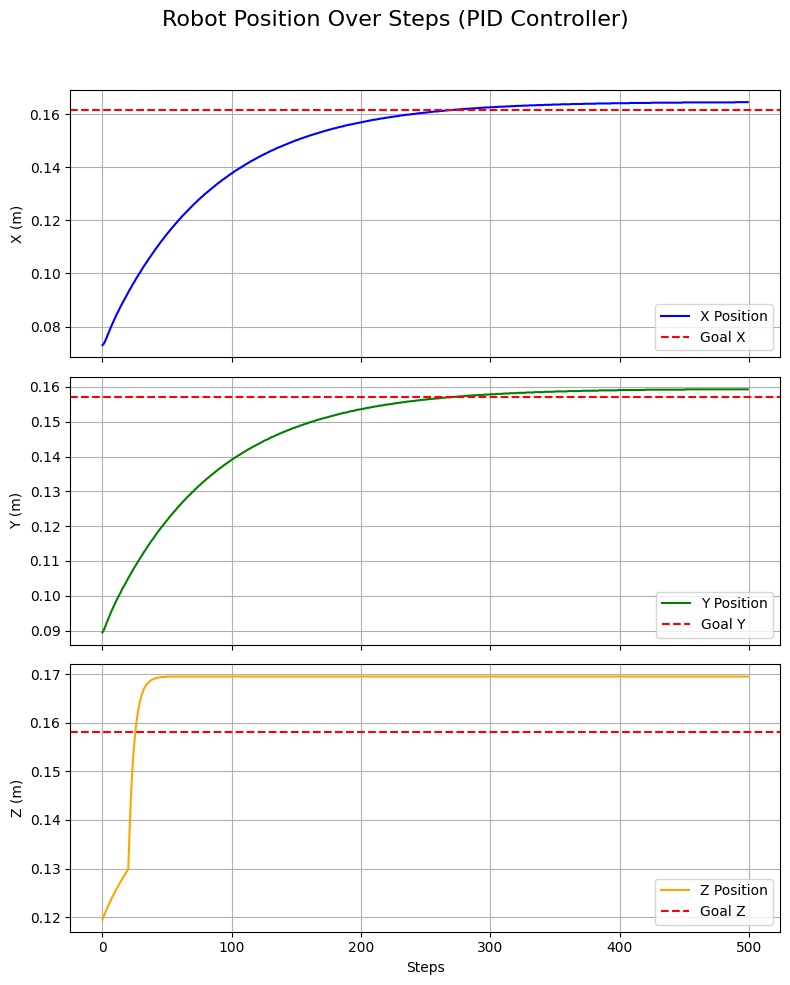


Final Accuracy:
  X-axis error: 0.0029 m
  Y-axis error: 0.0022 m
  Z-axis error: 0.0113 m


In [324]:
import time
import numpy as np
import matplotlib.pyplot as plt  # <-- Make sure to import matplotlib
from ot2_env_wrapper_updated import OT2Env

# PID Controller Class
class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def compute(self, current_position, dt):
        error = self.setpoint - current_position
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt if dt > 0 else 0
        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        # Anti-windup: Dynamically limit the integral term
        max_integral = 0.5
        self.integral = max(min(self.integral, max_integral), -max_integral)

        self.previous_error = error
        return output

# Environment Wrapper with PID Integration
class OT2EnvWithPID(OT2Env):
    def __init__(self, render=False, max_steps=500):
        super(OT2EnvWithPID, self).__init__(render, max_steps)

        # Initialize PID controllers for X, Y, Z axes
        self.pid_x = PIDController(kp=25.0, ki=0.3, kd=0.0, setpoint=0.0)
        self.pid_y = PIDController(kp=21.0, ki=0.3, kd=0.0, setpoint=0.0)
        self.pid_z = PIDController(kp=2.5, ki=0.2, kd=0.0, setpoint=0.0)

        # Set a random goal position
        self.goal_position = np.array([
            np.random.uniform(-0.187, 0.253),
            np.random.uniform(-0.1705, 0.2195),
            np.random.uniform(0.1195, 0.2895)
        ], dtype=np.float32)

        # ---------------------------------------------------------
        # Lists to store the robot's position history for plotting
        # ---------------------------------------------------------
        self.x_positions = []
        self.y_positions = []
        self.z_positions = []

    def step(self, action):
        # Update PID setpoints with goal position
        self.pid_x.setpoint = self.goal_position[0]
        self.pid_y.setpoint = self.goal_position[1]
        self.pid_z.setpoint = self.goal_position[2]

        # Get current pipette position
        robot_id_key = f'robotId_{self.sim.robotIds[0]}'
        pipette_position = self.sim.get_states()[robot_id_key]['pipette_position']

        # Compute corrections using PID controllers
        dt = 0.005  # further reduced time step for higher precision
        distance = np.linalg.norm(pipette_position - self.goal_position)

        # Dynamic gain adjustment based on distance
        scaling_factor = max(1.0, min(10.0, distance * 10))  # Scale between 1x and 10x
        self.pid_x.kp = 3.0 * scaling_factor
        self.pid_y.kp = 3.0 * scaling_factor
        self.pid_z.kp = 3.5 * scaling_factor

        correction_x = self.pid_x.compute(pipette_position[0], dt)
        correction_y = self.pid_y.compute(pipette_position[1], dt)
        correction_z = self.pid_z.compute(pipette_position[2], dt)

        # Combine corrections into action
        pid_action = [correction_x, correction_y, correction_z, action[-1]]  # include drop action

        # Execute the action in the simulation
        observation, reward, terminated, truncated, info = super().step(pid_action)

        # -------------------------------------------
        # Store the pipette position for plotting
        # -------------------------------------------
        self.x_positions.append(pipette_position[0])
        self.y_positions.append(pipette_position[1])
        self.z_positions.append(pipette_position[2])

        # Modify reward based on PID performance
        distance = np.linalg.norm(pipette_position - self.goal_position)
        reward = -distance  # Reward is negative distance to goal

        # Print current distance to goal in millimeters
        distance_mm = distance * 1000
        print(f"Step {self.steps}: Distance to Goal: {distance_mm:.3f} mm")

        # Termination condition: 1 mm threshold for accuracy
        termination_threshold = 0.001
        terminated = distance < termination_threshold

        return observation, reward, terminated, truncated, info

    def plot_trajectories(self):
        """
        Plot the X, Y, Z positions over steps, including the goal lines.
        """
        if not self.x_positions or not self.y_positions or not self.z_positions:
            print("No position data to plot.")
            return

        # Get final step count (x-axis range)
        steps = range(len(self.x_positions))

        # Goal positions
        goal_x, goal_y, goal_z = self.goal_position

        # Create subplots
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
        fig.suptitle("Robot Position Over Steps (PID Controller)", fontsize=16)

        # X subplot
        axes[0].plot(steps, self.x_positions, label='X Position', color='blue')
        axes[0].axhline(y=goal_x, color='red', linestyle='--', label='Goal X')
        axes[0].set_ylabel('X (m)')
        axes[0].legend()
        axes[0].grid(True)

        # Y subplot
        axes[1].plot(steps, self.y_positions, label='Y Position', color='green')
        axes[1].axhline(y=goal_y, color='red', linestyle='--', label='Goal Y')
        axes[1].set_ylabel('Y (m)')
        axes[1].legend()
        axes[1].grid(True)

        # Z subplot
        axes[2].plot(steps, self.z_positions, label='Z Position', color='orange')
        axes[2].axhline(y=goal_z, color='red', linestyle='--', label='Goal Z')
        axes[2].set_ylabel('Z (m)')
        axes[2].set_xlabel('Steps')
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Print final accuracy in each axis
        final_x = self.x_positions[-1]
        final_y = self.y_positions[-1]
        final_z = self.z_positions[-1]

        final_x_accuracy = abs(goal_x - final_x)
        final_y_accuracy = abs(goal_y - final_y)
        final_z_accuracy = abs(goal_z - final_z)

        print(f"\nFinal Accuracy:")
        print(f"  X-axis error: {final_x_accuracy:.4f} m")
        print(f"  Y-axis error: {final_y_accuracy:.4f} m")
        print(f"  Z-axis error: {final_z_accuracy:.4f} m")

# Simulation Function
if __name__ == "__main__":
    # Initialize environment with PID integration
    env = OT2EnvWithPID(render=False, max_steps=500)
    print(f"Goal Position: {env.goal_position}")

    # Reset environment
    obs, _ = env.reset()

    # Simulate steps
    for step in range(500):
        # Example action: [0, 0, 0, 0] 
        # (the actual motion is determined by the PID corrections inside env.step())
        action = [0, 0, 0, 0]
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step {step}: Reward = {reward:.4f}, Terminated = {terminated}, Truncated = {truncated}")

        if terminated or truncated:
            break

    print("\nSimulation complete.")
    # Call plot function to visualize X, Y, Z over time
    env.plot_trajectories()
    env.close()


Successfully loaded:
  Main texture:  textures\05.png
  Plate texture: textures/_plates\034_43-13-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_02-Fish Eye Corrected.png
Goal Position: [0.05562299 0.11722238 0.27973178]
Step 1: Distance to Goal: 142.011 mm
Step 0: Reward = -0.1420, Terminated = False, Truncated = False
Step 2: Distance to Goal: 141.367 mm
Step 1: Reward = -0.1414, Terminated = False, Truncated = False
Step 3: Distance to Goal: 140.412 mm
Step 2: Reward = -0.1404, Terminated = False, Truncated = False
Step 4: Distance to Goal: 139.069 mm
Step 3: Reward = -0.1391, Terminated = False, Truncated = False
Step 5: Distance to Goal: 137.121 mm
Step 4: Reward = -0.1371, Terminated = False, Truncated = False
Step 6: Distance to Goal: 134.793 mm
Step 5: Reward = -0.1348, Terminated = False, Truncated = False
Step 7: Distance to Goal: 132.549 mm
Step 6: Reward = -0.1325, Terminated = False, Truncated = False
Step 8: Distance to Goal: 130.329 mm
Step 7: Reward = -0.1303, Terminated = Fal

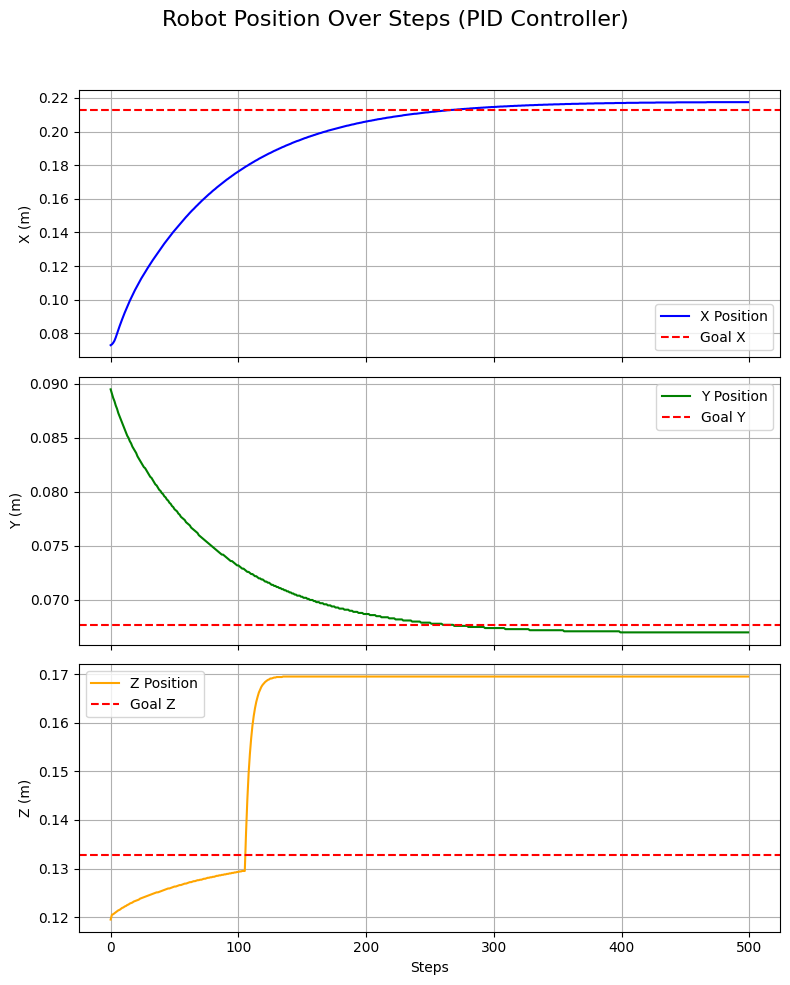


Final Accuracy:
  X-axis error: 0.0048 m
  Y-axis error: 0.0007 m
  Z-axis error: 0.0366 m


In [463]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ot2_env_wrapper_updated import OT2Env

# PID Controller Class
class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def compute(self, current_position, dt):
        error = self.setpoint - current_position
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt if dt > 0 else 0
        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        # Anti-windup: Dynamically limit the integral term
        max_integral = 0.5
        self.integral = max(min(self.integral, max_integral), -max_integral)

        self.previous_error = error
        return output

# Environment Wrapper with PID Integration
class OT2EnvWithPID(OT2Env):
    def __init__(self, render=False, max_steps=500):
        super(OT2EnvWithPID, self).__init__(render, max_steps)

        # Initialize PID controllers for X, Y, Z axes
        self.pid_x = PIDController(kp=22.0, ki=0.33, kd=0.0, setpoint=0.0)
        self.pid_y = PIDController(kp=18.0, ki=0.33, kd=0.0, setpoint=0.0)
        self.pid_z = PIDController(kp=14.0, ki=0.37, kd=0.1, setpoint=0.0)

        # Set a random goal position
        self.goal_position = np.array([
            np.random.uniform(-0.187, 0.253),
            np.random.uniform(-0.1705, 0.2195),
            np.random.uniform(0.1195, 0.2895)
        ], dtype=np.float32)

        # ---------------------------------------------------------
        # Lists to store the robot's position history for plotting
        # ---------------------------------------------------------
        self.x_positions = []
        self.y_positions = []
        self.z_positions = []

    def step(self, action):
        # Update PID setpoints with goal position
        self.pid_x.setpoint = self.goal_position[0]
        self.pid_y.setpoint = self.goal_position[1]
        self.pid_z.setpoint = self.goal_position[2]

        # Get current pipette position
        robot_id_key = f'robotId_{self.sim.robotIds[0]}'
        pipette_position = self.sim.get_states()[robot_id_key]['pipette_position']

        # Compute corrections using PID controllers
        dt = 0.005  # further reduced time step for higher precision
        distance = np.linalg.norm(pipette_position - self.goal_position)

        # Dynamic gain adjustment based on distance
        scaling_factor = max(1.0, min(10.0, distance * 10))  # Scale between 1x and 10x
        self.pid_x.kp = 3.0 * scaling_factor
        self.pid_y.kp = 3.0 * scaling_factor
        self.pid_z.kp = 3.0 * scaling_factor

        correction_x = self.pid_x.compute(pipette_position[0], dt)
        correction_y = self.pid_y.compute(pipette_position[1], dt)
        correction_z = self.pid_z.compute(pipette_position[2], dt)

        # Combine corrections into action
        pid_action = [correction_x, correction_y, correction_z, action[-1]]  # include drop action

        # Execute the action in the simulation
        observation, reward, terminated, truncated, info = super().step(pid_action)

        # -------------------------------------------
        # Store the pipette position for plotting
        # -------------------------------------------
        self.x_positions.append(pipette_position[0])
        self.y_positions.append(pipette_position[1])
        self.z_positions.append(pipette_position[2])

        # Modify reward based on PID performance
        distance = np.linalg.norm(pipette_position - self.goal_position)
        reward = -distance  # Reward is negative distance to goal

        # Print current distance to goal in millimeters
        distance_mm = distance * 1000
        print(f"Step {self.steps}: Distance to Goal: {distance_mm:.3f} mm")

        # Termination condition: 1 mm threshold for accuracy
        termination_threshold = 0.001
        terminated = distance < termination_threshold

        return observation, reward, terminated, truncated, info

    def plot_trajectories(self):
        """
        Plot the X, Y, Z positions over steps, including the goal lines.
        """
        if not self.x_positions or not self.y_positions or not self.z_positions:
            print("No position data to plot.")
            return

        # Get final step count (x-axis range)
        steps = range(len(self.x_positions))

        # Goal positions
        goal_x, goal_y, goal_z = self.goal_position

        # Create subplots
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
        fig.suptitle("Robot Position Over Steps (PID Controller)", fontsize=16)

        # X subplot
        axes[0].plot(steps, self.x_positions, label='X Position', color='blue')
        axes[0].axhline(y=goal_x, color='red', linestyle='--', label='Goal X')
        axes[0].set_ylabel('X (m)')
        axes[0].legend()
        axes[0].grid(True)

        # Y subplot
        axes[1].plot(steps, self.y_positions, label='Y Position', color='green')
        axes[1].axhline(y=goal_y, color='red', linestyle='--', label='Goal Y')
        axes[1].set_ylabel('Y (m)')
        axes[1].legend()
        axes[1].grid(True)

        # Z subplot
        axes[2].plot(steps, self.z_positions, label='Z Position', color='orange')
        axes[2].axhline(y=goal_z, color='red', linestyle='--', label='Goal Z')
        axes[2].set_ylabel('Z (m)')
        axes[2].set_xlabel('Steps')
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Print final accuracy in each axis
        final_x = self.x_positions[-1]
        final_y = self.y_positions[-1]
        final_z = self.z_positions[-1]

        final_x_accuracy = abs(goal_x - final_x)
        final_y_accuracy = abs(goal_y - final_y)
        final_z_accuracy = abs(goal_z - final_z)

        print(f"\nFinal Accuracy:")
        print(f"  X-axis error: {final_x_accuracy:.4f} m")
        print(f"  Y-axis error: {final_y_accuracy:.4f} m")
        print(f"  Z-axis error: {final_z_accuracy:.4f} m")

# Simulation Function
if __name__ == "__main__":
    # Initialize environment with PID integration
    env = OT2EnvWithPID(render=False, max_steps=500)
    print(f"Goal Position: {env.goal_position}")

    # Reset environment
    obs, _ = env.reset()

    # Simulate steps
    for step in range(500):
        # Example action: [0, 0, 0, 0] 
        # (the actual motion is determined by the PID corrections inside env.step())
        action = [0, 0, 0, 0]
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step {step}: Reward = {reward:.4f}, Terminated = {terminated}, Truncated = {truncated}")

        if terminated or truncated:
            break

    print("\nSimulation complete.")
    # Call plot function to visualize X, Y, Z over time
    env.plot_trajectories()
    env.close()


Successfully loaded:
  Main texture:  textures\01.png
  Plate texture: textures/_plates\030_43-2-ROOT1-2023-08-08_pvdCherry_OD001_Col0_05-Fish Eye Corrected.png
Goal Position: [0.1491816  0.08002876 0.15664327]
Step 1: Distance to Goal: 165.779 mm
Step 0: Reward = -0.1658, Terminated = False, Truncated = False
Step 2: Distance to Goal: 164.616 mm
Step 1: Reward = -0.1646, Terminated = False, Truncated = False
Step 3: Distance to Goal: 162.516 mm
Step 2: Reward = -0.1625, Terminated = False, Truncated = False
Step 4: Distance to Goal: 159.898 mm
Step 3: Reward = -0.1599, Terminated = False, Truncated = False
Step 5: Distance to Goal: 156.825 mm
Step 4: Reward = -0.1568, Terminated = False, Truncated = False
Step 6: Distance to Goal: 153.801 mm
Step 5: Reward = -0.1538, Terminated = False, Truncated = False
Step 7: Distance to Goal: 150.791 mm
Step 6: Reward = -0.1508, Terminated = False, Truncated = False
Step 8: Distance to Goal: 144.143 mm
Step 7: Reward = -0.1441, Terminated = False,

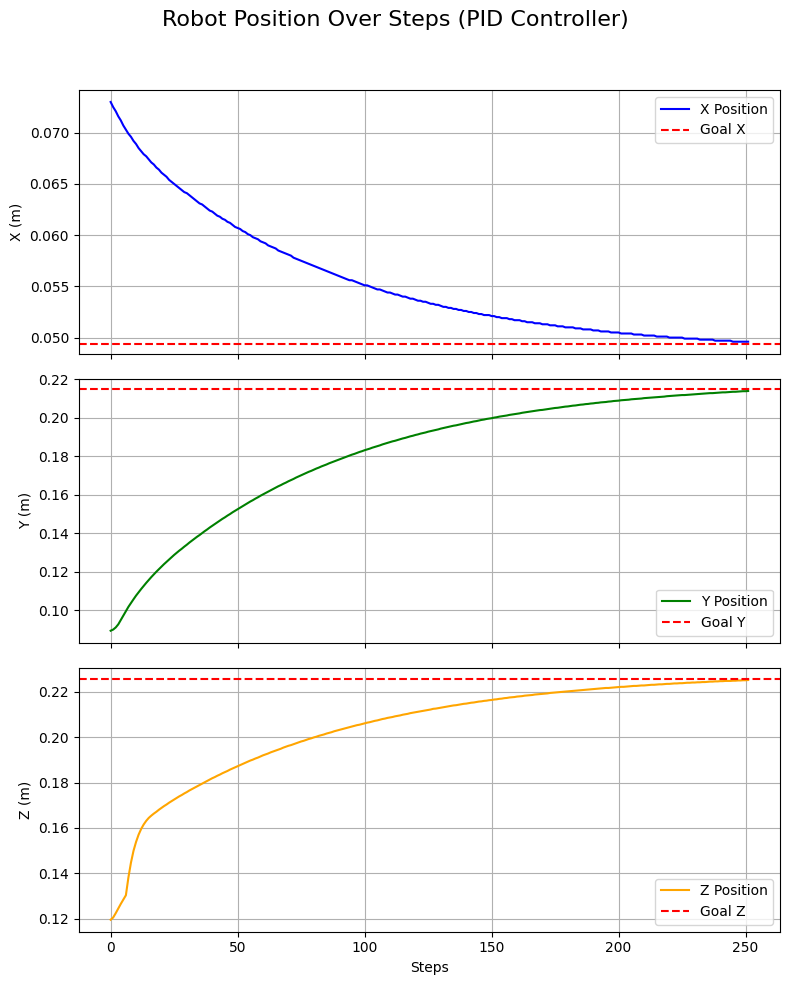


Final Accuracy:
  X-axis error: 0.0002 m
  Y-axis error: 0.0009 m
  Z-axis error: 0.0004 m


In [485]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ot2_env_wrapper_updated import OT2Env

# PID Controller Class
class PIDController:
    def __init__(self, kp, ki, kd, setpoint):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def compute(self, current_position, dt):
        error = self.setpoint - current_position
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt if dt > 0 else 0
        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        # Anti-windup: Dynamically limit the integral term
        max_integral = 0.5
        self.integral = max(min(self.integral, max_integral), -max_integral)

        self.previous_error = error
        return output

# Environment Wrapper with PID Integration
class OT2EnvWithPID(OT2Env):
    def __init__(self, render=False, max_steps=500):
        super(OT2EnvWithPID, self).__init__(render, max_steps)

        # Initialize PID controllers for X, Y, Z axes
        self.pid_x = PIDController(kp=18.0, ki=0.33, kd=0.0, setpoint=0.0)
        self.pid_y = PIDController(kp=18.0, ki=0.33, kd=0.0, setpoint=0.0)
        self.pid_z = PIDController(kp=18.0, ki=0.33, kd=0.0, setpoint=0.0)

        # Set a random goal position
        self.goal_position = np.array([
            np.random.uniform(-0.187, 0.253),
            np.random.uniform(-0.1705, 0.2195),
            np.random.uniform(0.1195, 0.2895)
        ], dtype=np.float32)

        # ---------------------------------------------------------
        # Lists to store the robot's position history for plotting
        # ---------------------------------------------------------
        self.x_positions = []
        self.y_positions = []
        self.z_positions = []

    def step(self, action):
        # Update PID setpoints with goal position
        self.pid_x.setpoint = self.goal_position[0]
        self.pid_y.setpoint = self.goal_position[1]
        self.pid_z.setpoint = self.goal_position[2]

        # Get current pipette position
        robot_id_key = f'robotId_{self.sim.robotIds[0]}'
        pipette_position = self.sim.get_states()[robot_id_key]['pipette_position']

        # Compute corrections using PID controllers
        dt = 0.005  # further reduced time step for higher precision
        distance = np.linalg.norm(pipette_position - self.goal_position)

        # Dynamic gain adjustment based on distance
        scaling_factor = max(1.0, min(10.0, distance * 10))  # Scale between 1x and 10x
        self.pid_x.kp = 3.0 * scaling_factor
        self.pid_y.kp = 3.0 * scaling_factor
        self.pid_z.kp = 3.0 * scaling_factor

        correction_x = self.pid_x.compute(pipette_position[0], dt)
        correction_y = self.pid_y.compute(pipette_position[1], dt)
        correction_z = self.pid_z.compute(pipette_position[2], dt)

        # Combine corrections into action
        pid_action = [correction_x, correction_y, correction_z, action[-1]]  # include drop action

        # Execute the action in the simulation
        observation, reward, terminated, truncated, info = super().step(pid_action)

        # -------------------------------------------
        # Store the pipette position for plotting
        # -------------------------------------------
        self.x_positions.append(pipette_position[0])
        self.y_positions.append(pipette_position[1])
        self.z_positions.append(pipette_position[2])

        # Modify reward based on PID performance
        distance = np.linalg.norm(pipette_position - self.goal_position)
        reward = -distance  # Reward is negative distance to goal

        # Print current distance to goal in millimeters
        distance_mm = distance * 1000
        print(f"Step {self.steps}: Distance to Goal: {distance_mm:.3f} mm")

        # Termination condition: 1 mm threshold for accuracy
        termination_threshold = 0.001
        terminated = distance < termination_threshold

        return observation, reward, terminated, truncated, info

    def plot_trajectories(self):
        """
        Plot the X, Y, Z positions over steps, including the goal lines.
        """
        if not self.x_positions or not self.y_positions or not self.z_positions:
            print("No position data to plot.")
            return

        # Get final step count (x-axis range)
        steps = range(len(self.x_positions))

        # Goal positions
        goal_x, goal_y, goal_z = self.goal_position

        # Create subplots
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
        fig.suptitle("Robot Position Over Steps (PID Controller)", fontsize=16)

        # X subplot
        axes[0].plot(steps, self.x_positions, label='X Position', color='blue')
        axes[0].axhline(y=goal_x, color='red', linestyle='--', label='Goal X')
        axes[0].set_ylabel('X (m)')
        axes[0].legend()
        axes[0].grid(True)

        # Y subplot
        axes[1].plot(steps, self.y_positions, label='Y Position', color='green')
        axes[1].axhline(y=goal_y, color='red', linestyle='--', label='Goal Y')
        axes[1].set_ylabel('Y (m)')
        axes[1].legend()
        axes[1].grid(True)

        # Z subplot
        axes[2].plot(steps, self.z_positions, label='Z Position', color='orange')
        axes[2].axhline(y=goal_z, color='red', linestyle='--', label='Goal Z')
        axes[2].set_ylabel('Z (m)')
        axes[2].set_xlabel('Steps')
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Print final accuracy in each axis
        final_x = self.x_positions[-1]
        final_y = self.y_positions[-1]
        final_z = self.z_positions[-1]

        final_x_accuracy = abs(goal_x - final_x)
        final_y_accuracy = abs(goal_y - final_y)
        final_z_accuracy = abs(goal_z - final_z)

        print(f"\nFinal Accuracy:")
        print(f"  X-axis error: {final_x_accuracy:.4f} m")
        print(f"  Y-axis error: {final_y_accuracy:.4f} m")
        print(f"  Z-axis error: {final_z_accuracy:.4f} m")

# Simulation Function
if __name__ == "__main__":
    # Initialize environment with PID integration
    env = OT2EnvWithPID(render=False, max_steps=500)
    print(f"Goal Position: {env.goal_position}")

    # Reset environment
    obs, _ = env.reset()

    # Simulate steps
    for step in range(500):
        # Example action: [0, 0, 0, 0] 
        # (the actual motion is determined by the PID corrections inside env.step())
        action = [0, 0, 0, 0]
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step {step}: Reward = {reward:.4f}, Terminated = {terminated}, Truncated = {truncated}")

        if terminated or truncated:
            break

    print("\nSimulation complete.")
    # Call plot function to visualize X, Y, Z over time
    env.plot_trajectories()
    env.close()
